In [19]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Convolution1D
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.io import loadmat



In [20]:
timesteps = 240, # timestep
nr = 90   # repetition number
n_dim = 117  # Dimension of data sequences
dropout_rate = 0.2   # Droput rate

In [21]:
x = loadmat('M1-DeepSquat.mat')
correct = x['Train_Data']
T1 = correct.shape[1]
incorrect = x['Test_Data']
T2 = incorrect.shape[1]
Correct_label = np.loadtxt('Score_Train.csv', delimiter = ',')
Incorrect_label = np.loadtxt('Score_Test.csv', delimiter = ',')
Correct_label = np.reshape(Correct_label,(90,1))
Incorrect_label = np.reshape(Incorrect_label,(90,1))

In [22]:
Train_Data = []
Test_Data = []
for i in range(T1):
    Train_Data.append(correct[0,i])
for i in range(T2):
    Test_Data.append(incorrect[0,i])
Train_Data = np.dstack(Train_Data)
Correct_data = np.rollaxis(Train_Data,-1)
Test_Data = np.dstack(Test_Data)
Incorrect_data = np.rollaxis(Test_Data,-1)

In [23]:
# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')
print(Incorrect_label)

(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels
[[0.43525341]
 [0.43465818]
 [0.43842419]
 [0.43581389]
 [0.43959024]
 [0.43689583]
 [0.43747998]
 [0.43957038]
 [0.43583371]
 [0.43911411]
 [0.43881282]
 [0.44086217]
 [0.43831279]
 [0.44034677]
 [0.43714758]
 [0.43991457]
 [0.44100035]
 [0.43980403]
 [0.43879309]
 [0.43987673]
 [0.43892337]
 [0.44142166]
 [0.44042199]
 [0.44029024]
 [0.43558695]
 [0.44955901]
 [0.44026599]
 [0.43794804]
 [0.43701636]
 [0.43908085]
 [0.4388534 ]
 [0.43990399]
 [0.44413918]
 [0.44403944]
 [0.44533624]
 [0.43836589]
 [0.4444067 ]
 [0.44158844]
 [0.44139656]
 [0.4406852 ]
 [0.44141096]
 [0.44377826]
 [0.44079774]
 [0.44280116]
 [0.4452911 ]
 [0.43994293]
 [0.43458184]
 [0.4374726 ]
 [0.43660319]
 [0.43932417]
 [0.44337643]
 [0.43812463]
 [0.43654265]
 [0.43832223]
 [0.43972428]
 [0.44215216]
 [0.44220035]
 [0.44577812]
 [0.44586616]
 [0.44330945]
 [0.44363054]
 [0.44277292]
 [0.44061836]
 [

In [24]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# First load the shuffled indices
f = open('Shuffled_Indices.csv')
csv_f = csv.reader(f)
indcs = list(csv_f)

# Extract the training and validation indices
trainidx1 = np.squeeze(np.asarray(indcs[:int(nr*0.7)], dtype = np.float64))
trainidx1 = np.asarray(trainidx1, dtype = np.int32)   # convert input to an array
valididx1 = np.squeeze(np.asarray(indcs[int(nr*0.7):nr], dtype = np.float64))
valididx1 = np.asarray(valididx1, dtype = np.int32)
trainidx2 = np.squeeze(np.asarray(indcs[nr:nr+int(nr*0.7)], dtype = np.float64))
trainidx2 = np.asarray(trainidx2, dtype = np.int32)
valididx2 = np.squeeze(np.asarray(indcs[nr+int(nr*0.7):], dtype = np.float64))
valididx2 = np.asarray(valididx2, dtype = np.int32)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')
# print(train_x[0].shape)

(124, 240, 117) training data
(124,) training labels
(56, 240, 117) validation data
(56,) validation labels


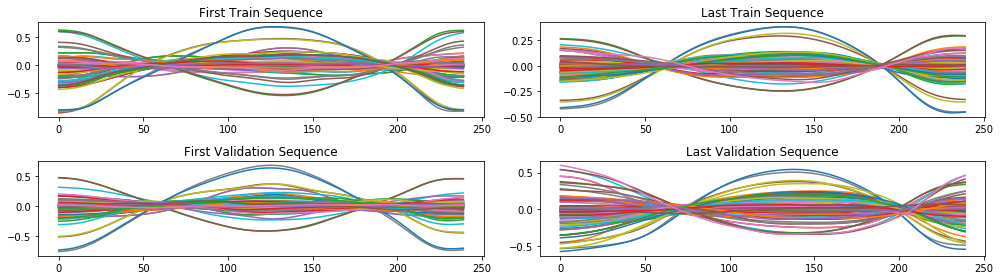

In [25]:
# Plot the first and last sequence in the training and validation data
%matplotlib inline
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [26]:
# Build CNN model ...
def Network():
    model = Sequential()
    model.add(Convolution1D(60, 5, padding ='same', strides = 2, input_shape = (240,117)))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(30, 3, padding ='same', strides = 2))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(10, 3, padding ='same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Flatten())

    model.add(Dense(200))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(100))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics = ['acc'])
    
    # Request to stop before reaching the number of epochs if the Validaton Loss does not decrease for 100 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

   
    history = model.fit(train_x, train_y, batch_size=5, epochs=5000, verbose=1, 
                     validation_data=(valid_x, valid_y),
                     callbacks = [early_stopping])

    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(train_x)
    pred_test = model.predict(valid_x)

    plt.figure(figsize = (14,4))
    plt.subplot(1,2,1)
    plt.plot(pred_train,'bo',train_y,'g*')
    plt.ylim([-0.1,1.1])
    plt.title('Labels for the training set')
    plt.subplot(1,2,2)
    plt.plot(pred_test,'bo',valid_y,'g*')
    plt.title('Labels for the testing set')
    plt.ylim([-0.1,1.1])
    plt.tight_layout()
    plt.show()
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    test_dev = abs(np.squeeze(pred_test)-valid_y)
    # Cumulative deviation
    mean_abs_dev = np.mean(test_dev)
    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
    print('Mean absolute deviation:', mean_abs_dev)
    print('RMS deviation:', rms_dev)
    
    return mean_abs_dev, rms_dev


Train on 124 samples, validate on 56 samples
Epoch 1/5000
124/124 [==============================] - 1s 10ms/step - loss: 0.6017 - acc: 0.0000e+00 - val_loss: 0.5463 - val_acc: 0.0000e+00
Epoch 2/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.5645 - acc: 0.0000e+00 - val_loss: 0.5349 - val_acc: 0.0000e+00
Epoch 3/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.5417 - acc: 0.0000e+00 - val_loss: 0.5287 - val_acc: 0.0000e+00
Epoch 4/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.5304 - acc: 0.0000e+00 - val_loss: 0.5576 - val_acc: 0.0000e+00
Epoch 5/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.5135 - acc: 0.0000e+00 - val_loss: 0.5092 - val_acc: 0.0000e+00
Epoch 6/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.5098 - acc: 0.0000e+00 - val_loss: 0.5162 - val_acc: 0.0000e+00
Epoch 7/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.5027 - acc: 0.0000e+00 -

124/124 [==============================] - 0s 1ms/step - loss: 0.4893 - acc: 0.0000e+00 - val_loss: 0.5002 - val_acc: 0.0000e+00
Epoch 59/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4918 - acc: 0.0000e+00 - val_loss: 0.4999 - val_acc: 0.0000e+00
Epoch 60/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.4880 - acc: 0.0000e+00 - val_loss: 0.5006 - val_acc: 0.0000e+00
Epoch 61/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.4879 - acc: 0.0000e+00 - val_loss: 0.4992 - val_acc: 0.0000e+00
Epoch 62/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4884 - acc: 0.0000e+00 - val_loss: 0.4997 - val_acc: 0.0000e+00
Epoch 63/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.4882 - acc: 0.0000e+00 - val_loss: 0.5002 - val_acc: 0.0000e+00
Epoch 64/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4881 - acc: 0.0000e+00 - val_loss: 0.5012 - val_acc: 0.0000e+00
Epoch 65/5000

124/124 [==============================] - 0s 1ms/step - loss: 0.4878 - acc: 0.0000e+00 - val_loss: 0.5028 - val_acc: 0.0000e+00
Epoch 116/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.4868 - acc: 0.0000e+00 - val_loss: 0.5067 - val_acc: 0.0000e+00
Epoch 117/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4872 - acc: 0.0000e+00 - val_loss: 0.5000 - val_acc: 0.0000e+00
Epoch 118/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4871 - acc: 0.0000e+00 - val_loss: 0.5112 - val_acc: 0.0000e+00
Epoch 119/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4870 - acc: 0.0000e+00 - val_loss: 0.5001 - val_acc: 0.0000e+00
Epoch 120/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4891 - acc: 0.0000e+00 - val_loss: 0.5066 - val_acc: 0.0000e+00
Epoch 121/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4890 - acc: 0.0000e+00 - val_loss: 0.5054 - val_acc: 0.0000e+00
Epoch 1

Epoch 172/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4863 - acc: 0.0000e+00 - val_loss: 0.5068 - val_acc: 0.0000e+00
Epoch 173/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4872 - acc: 0.0000e+00 - val_loss: 0.5032 - val_acc: 0.0000e+00
Epoch 174/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4865 - acc: 0.0000e+00 - val_loss: 0.4999 - val_acc: 0.0000e+00
Epoch 175/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4861 - acc: 0.0000e+00 - val_loss: 0.5008 - val_acc: 0.0000e+00
Epoch 176/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4862 - acc: 0.0000e+00 - val_loss: 0.5054 - val_acc: 0.0000e+00
Epoch 177/5000
124/124 [==============================] - 0s 2ms/step - loss: 0.4865 - acc: 0.0000e+00 - val_loss: 0.5021 - val_acc: 0.0000e+00
Epoch 178/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4867 - acc: 0.0000e+00 - val_loss: 0.5058 - val_acc: 0.0

Epoch 229/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4862 - acc: 0.0000e+00 - val_loss: 0.5124 - val_acc: 0.0000e+00
Epoch 230/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4863 - acc: 0.0000e+00 - val_loss: 0.5216 - val_acc: 0.0000e+00
Epoch 231/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4864 - acc: 0.0000e+00 - val_loss: 0.5090 - val_acc: 0.0000e+00
Epoch 232/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4861 - acc: 0.0000e+00 - val_loss: 0.5057 - val_acc: 0.0000e+00
Epoch 233/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4861 - acc: 0.0000e+00 - val_loss: 0.5185 - val_acc: 0.0000e+00
Epoch 234/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4861 - acc: 0.0000e+00 - val_loss: 0.5179 - val_acc: 0.0000e+00
Epoch 235/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4864 - acc: 0.0000e+00 - val_loss: 0.5029 - val_acc: 0.0

Epoch 286/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4860 - acc: 0.0000e+00 - val_loss: 0.5094 - val_acc: 0.0000e+00
Epoch 287/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4865 - acc: 0.0000e+00 - val_loss: 0.5028 - val_acc: 0.0000e+00
Epoch 288/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4863 - acc: 0.0000e+00 - val_loss: 0.4961 - val_acc: 0.0000e+00
Epoch 289/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4865 - acc: 0.0000e+00 - val_loss: 0.5002 - val_acc: 0.0000e+00
Epoch 290/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4865 - acc: 0.0000e+00 - val_loss: 0.5065 - val_acc: 0.0000e+00
Epoch 291/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4860 - acc: 0.0000e+00 - val_loss: 0.5017 - val_acc: 0.0000e+00
Epoch 292/5000
124/124 [==============================] - 0s 1ms/step - loss: 0.4869 - acc: 0.0000e+00 - val_loss: 0.5123 - val_acc: 0.0

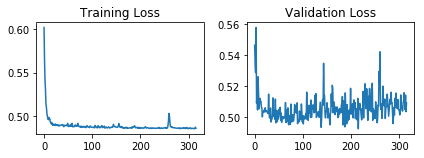

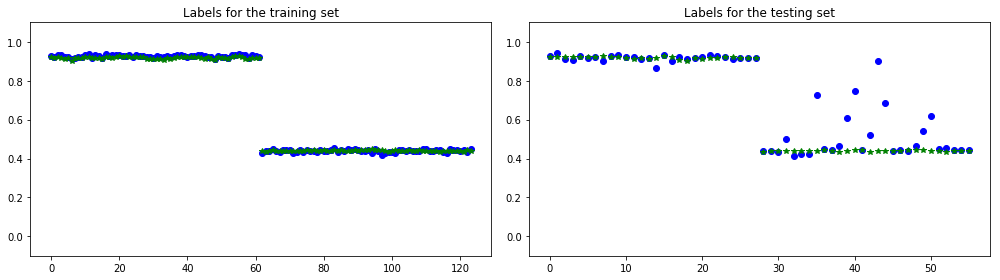

Mean absolute deviation: 0.04226792969618783
RMS deviation: 0.09818501385977345


In [27]:
# call the CNN model   
Mean_abs_dev, RMS_dev  = Network() 